# Test Tensorflow-federated (TFF) library

## Test #7 : final MNIST test

In [1]:
import os
import collections
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0]], 'GPU')

nest_asyncio.apply()

print('Tensorflow version : {}'.format(tf.__version__))
print('Tensorflow-federated version : {}'.format(tff.__version__))
print('# GPUs : {}'.format(len(tf.config.list_logical_devices('GPU'))))

tff.federated_computation(lambda: 'Hello, World!')()

2022-11-23 14:24:05.161660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 14:24:05.257359: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 14:24:05.281739: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

Tensorflow version : 2.10.0
Tensorflow-federated version : 0.39.0
# GPUs : 1


2022-11-23 14:24:13.955531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 14:24:14.334809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


b'Hello, World!'

In [2]:
import collections
import tensorflow as tf

from models.interfaces.base_fl_model import BaseFLModel
from models.interfaces.base_image_model import BaseImageModel

class MNISTFLClassifier(BaseImageModel, BaseFLModel):
    def __init__(self, input_size = (28, 28, 1), n_labels = 10, ** kwargs):
        self._init_image(input_size = input_size, ** kwargs)
        self._init_fl(** kwargs)
        
        self.n_labels = n_labels
        
        super().__init__(** kwargs)
    
    def _build_model(self, ** kwargs):
        # code from https://github.com/yui-mhcp/base_dl_project in models/classification/base_classifier.py
        final_activation = 'sigmoid' if self.n_labels <= 2 else 'softmax'
        config = {
            'architecture_name' : 'simple_cnn',
            'input_shape'   : self.input_size,
            'output_shape'  : 1 if self.n_labels <= 2 else self.n_labels,
            
            'n_conv'    : 2,
            'filters'   : 16,
            'kernel_size'   : 3,
            'strides'       : 1,
            'pooling'       : 'max',
            'bnorm'         : 'never',
                
            'dense_as_final'    : True,
            
            'n_dense'   : 1,
            'dense_size'    : 64,
            
            'final_activation'  : final_activation,
            'final_name'        : 'classification_layer',
            
            'name'  : 'cnn_classifier',
            ** kwargs
        }
            
        super()._build_model(model = config)
    
    @property
    def output_signature(self):
        return tf.TensorSpec(shape = (None, 1), dtype = tf.int32)
    
    def __str__(self):
        des = super().__str__()
        des += self._str_image()
        des += self._str_fl()
        des += '- # labels : {}\n'.format(self.n_labels)
        return des

    def compile(self, loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'], ** kwargs):
        super().compile(loss = loss, metrics = metrics, ** kwargs)
    
    def preprocess_data(self, data):
        return (
1. -             tf.expand_dims(data['pixels'], axis = -1),
            tf.cast(tf.reshape(data['label'], [-1, 1]), tf.int32)
        )
    
    def get_dataset_config(self, * args, ** kwargs):
        kwargs['batch_before_map'] = True
        return super().get_dataset_config(* args, ** kwargs)
    
    def get_config(self, * args, ** kwargs):
        config = super().get_config(* args, ** kwargs)
        config.update({
            ** self.get_config_image(),
            ** self.get_config_fl(),
            'n_labels' : self.n_labels
        })
        return config
    
    
model = MNISTFLClassifier(nom = 'test_fl_7')
model.compile(optimizer = 'sgd')
print(model)
model.summary()


========== test_fl_7 ==========
Sub model model
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 14
- Number of parameters 	: 0.028 Millions
- Optimizer 	: {'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
- Loss 	 : {'reduction': 'none', 'name': 'sparse_categorical_crossentropy', 'from_logits': False, 'ignore_class': None}
- Metrics	 : [{'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}]

Already trained on 48 epochs (48 steps)

- Image size : (28, 28, 1)
- Normalization style : None
- # labels : 10


========== Summary of model ==========

Model: "cnn_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 activation (Activation)     (None, 28, 28, 16)        0         
                      

In [3]:
emnist_train, emnist_valid = tff.simulation.datasets.emnist.load_data()
print('Dataset length :\n  Train length : {}\n  Valid length : {}'.format(
    len(emnist_train.client_ids), len(emnist_valid.client_ids)
))
print('Data signature : {}'.format(emnist_train.element_type_structure))

Dataset length :
  Train length : 3383
  Valid length : 3383
Data signature : OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


## Training

INFO:models.interfaces.base_fl_model:# train clients : 1
# valid clients : 1
Training config :
HParams :
- augment_prct	: 0.25
- batch_size	: 8
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 1024
- epochs	: 10
- verbose	: 1
- train_times	: 10
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- n_clients	: 1
- n_train_clients	: None
- n_valid_clients	: None
- server_optimizer_fn	: 0.01
- client_optimizer_fn	: 0.005
- reconstruction_optimizer_fn	: None

INFO:models.interfaces.base_fl_model:(<
  state=<
    global_model_weights=<
      trainable=<
        float32[3,3,1,16],
        float32[16],
        float32[3,3,16,16],
        float32[16],
        float32[784,32],
        float32[32],
        float32[32,10]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<>,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<
      int64
    >
  >@S

OrderedDict([('sparse_categorical_accuracy', 0.11176471), ('loss', 2.3000164), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3034565), ('val_num_examples', 12), ('val_num_batches', 2)])


2022-11-23 14:30:09.699012: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
INFO:models.interfaces.base_fl_model:
Epoch 51 / 58


OrderedDict([('sparse_categorical_accuracy', 0.11372549), ('loss', 2.2999423), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3032985), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 52 / 58


OrderedDict([('sparse_categorical_accuracy', 0.11960784), ('loss', 2.3004794), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3031456), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 53 / 58


OrderedDict([('sparse_categorical_accuracy', 0.110784315), ('loss', 2.3001027), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3033981), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 54 / 58


OrderedDict([('sparse_categorical_accuracy', 0.11666667), ('loss', 2.3002033), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3033996), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 55 / 58


OrderedDict([('sparse_categorical_accuracy', 0.120588236), ('loss', 2.300311), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.303569), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 56 / 58


OrderedDict([('sparse_categorical_accuracy', 0.10784314), ('loss', 2.3007371), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3031623), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 57 / 58


OrderedDict([('sparse_categorical_accuracy', 0.11960784), ('loss', 2.3005848), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3032813), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:
Epoch 58 / 58


OrderedDict([('sparse_categorical_accuracy', 0.10784314), ('loss', 2.3001251), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3031807), ('val_num_examples', 12), ('val_num_batches', 2)])


INFO:models.interfaces.base_fl_model:Training finished after 6.437 sec !
INFO:models.interfaces.base_model:Submodel model saved in pretrained_models/test_fl_7/saving/model.json !


OrderedDict([('sparse_categorical_accuracy', 0.1127451), ('loss', 2.3006964), ('num_examples', 1020), ('num_batches', 130), ('val_sparse_categorical_accuracy', 0.16666667), ('val_loss', 2.3031564), ('val_num_examples', 12), ('val_num_batches', 2)])
===== History =====
    sparse_categorical_accuracy      loss  val_sparse_categorical_accuracy  \
0                      0.100329  2.310351                         0.105492   
1                      0.102355  2.307794                         0.096115   
2                      0.101782  2.306252                         0.106497   
3                      0.100462  2.305720                         0.102813   
4                      0.100982  2.304870                         0.109176   
5                      0.102821  2.304443                         0.116879   
6                      0.103648  2.304291                         0.098125   
7                      0.101542  2.303653                         0.108841   
8                      0.1041

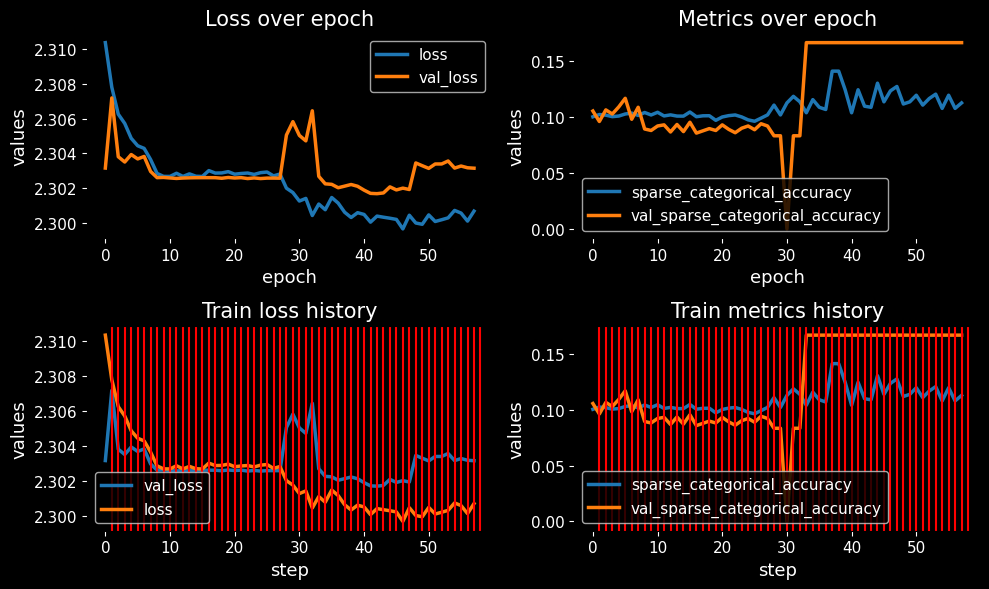

In [6]:
from loggers import set_level

set_level('info', 'models')
h = model.train_fl(
    emnist_train, validation_data = emnist_valid,
    epochs      = 10,
    batch_size  = 8,
    train_times = 10,
    n_clients   = 1,
    server_optimizer_fn = 0.01,
    client_optimizer_fn = 0.005,
    verbose = 0
)
print(h)
h.plot()

In [5]:
h.plot(filename = 'example_history_2.png')

In [4]:
ds = model._get_fl_train_config(emnist_train, validation_data = emnist_valid, n_clients = 1)['x']

for (inp, out) in ds[0]:
    print(out[:, 0])
    pred = tf.argmax(model(inp, training = False), axis = -1)
    print(pred)
    print(np.mean(out[:, 0] == tf.cast(pred, tf.int32)))

tf.Tensor([8 5 4 9 0 4 2 5 3 6 3 7 8 1 2 5], shape=(16,), dtype=int32)


2022-11-23 14:24:17.804533: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


tf.Tensor([3 3 5 5 5 0 3 3 3 3 3 0 3 3 3 3], shape=(16,), dtype=int64)
0.125
tf.Tensor([4 0 7 3 9 5 3 0 2 6 7 0 7 4 5 7], shape=(16,), dtype=int32)
tf.Tensor([5 3 0 3 0 5 5 5 3 3 0 5 0 5 3 0], shape=(16,), dtype=int64)
0.125
tf.Tensor([9 4 3 2 9 4 6 7 1 3 7 1 6 1 0 0], shape=(16,), dtype=int32)
tf.Tensor([0 3 3 3 0 5 3 0 3 3 0 3 3 3 3 3], shape=(16,), dtype=int64)
0.125
tf.Tensor([9 4 0 6 5 6 9 8 6 6 3 8 4 4 7 1], shape=(16,), dtype=int32)
tf.Tensor([0 3 3 5 5 3 5 3 3 3 3 3 5 5 0 3], shape=(16,), dtype=int64)
0.125
tf.Tensor([1 7 5 5 3 6 9 8 1 8 0 2 0 9 6 1], shape=(16,), dtype=int32)
tf.Tensor([5 0 3 3 5 3 5 3 5 3 3 3 5 5 5 0], shape=(16,), dtype=int64)
0.0
tf.Tensor([1 1 0 3 2 3 7 5 4 0 2 8 2 1 3 1], shape=(16,), dtype=int32)
tf.Tensor([5 5 3 3 3 3 0 3 5 5 3 3 3 3 3 3], shape=(16,), dtype=int64)
0.1875
tf.Tensor([5 5 4 5 9 2], shape=(6,), dtype=int32)
tf.Tensor([3 3 0 3 5 5], shape=(6,), dtype=int64)
0.0


In [5]:
model(inp, training = False)

<tf.Tensor: shape=(6, 10), dtype=float32, numpy=
array([[0.10025556, 0.09972753, 0.10008925, 0.10125566, 0.10042845,
        0.10086559, 0.09951583, 0.09995353, 0.09830179, 0.09960686],
       [0.10066865, 0.09931374, 0.10018337, 0.10178459, 0.10065378,
        0.10101371, 0.09904992, 0.09979843, 0.09866469, 0.09886912],
       [0.10082739, 0.0994857 , 0.09998666, 0.1005827 , 0.10037609,
        0.10057805, 0.09962343, 0.10016481, 0.09873527, 0.09963985],
       [0.10045095, 0.09955007, 0.09972592, 0.10188031, 0.1003864 ,
        0.10127632, 0.09959978, 0.099717  , 0.09833569, 0.09907755],
       [0.10069439, 0.09957798, 0.10036312, 0.10095096, 0.10057015,
        0.10129216, 0.09898187, 0.0998641 , 0.09868078, 0.09902453],
       [0.10045785, 0.09951948, 0.09947699, 0.10102101, 0.1004594 ,
        0.10105804, 0.09964371, 0.09977237, 0.09866961, 0.09992155]],
      dtype=float32)>

In [ ]:
from utils import plot

plot(1. - inp[0])